In [26]:
#Import relevant libraries
import io
import itertools
import sklearn.metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorboard.plugins.hparams import api as hp

In [27]:
#Dataset encoding explaination.
#image labelling - 0=glasses/sunglasses. 1= trousers/jeans. 3= shoes

In [28]:
#Import the datasets and preprocess

data_train = np.load(r'Full Dataset/primary categories - Train.npz')
data_validation = np.load(r'Full Dataset/primary categories - Validation.npz')
data_Test = np.load(r'Full Dataset/primary categories - Test.npz')


#t extract the arrays from dataset into input(images) and target(labels)
images_train = data_train['images']
labels_train = data_train['labels']

images_val = data_train['images']
labels_val = data_train['labels']


images_test = data_train['images']
labels_test = data_train['labels']

#Pixel-wise normalization of the training, validation and testing data
images_train = images_train/255.0
images_val  = images_val/255.0
images_test = images_test/255.0







In [29]:
#Define the hyperparameters

BATCH_SIZE = 64
EPOCHS = 5

#Define the hyperparamets to tune and the variations we want to test.
HP_FILTER_SIZE = hp.HParam('filter_size', hp.Discrete([3,5,7]))
HP_FILTER_NUM = hp.HParam('filter_num', hp.Discrete(['32','64','96', '128']))

METRIC_ACCURACY = 'accuracy'

#Log the hyperparameter with the file writer
with tf.summary.create_file_writer('Logs/Model 1/hparam_tuning/').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE, HP_FILTER_NUM], 
        metrics= [hp.Metric(METRIC_ACCURACY, display_name='Accuracy')]
    )



In [30]:
# #Create and train the model


# session_num = 0
# model = Sequential([
#             Conv2D(32, 3, activation= 'relu', input_shape=(120,90,3)),
#             MaxPooling2D(pool_size=(2,2)),
#             Conv2D(HP_FILTER_NUM, 3, activation= 'relu'),
#             MaxPooling2D(pool_size=(2,2)),
#             Flatten(),
#             Dense(3)
# ])
    
    
# #describe the loss function
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# #Compile the model
# model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# log_dir = f"Logs/Model 1/fit/run-{session_num}"






In [31]:
# # Create a Confusion Matrix

# def make_predictions(images_val):
#     predictions = model.predict(images_val)
#     return predictions


# def confusion_matrix_callback(epoch,log=None):
    
#     val_predict_raw= make_predictions(images_val)
#     val_predict = np.argmax(val_predict_raw, axis =1)



#     cm = confusion_matrix(labels_val, val_predict)

#     # Define class labels
#     class_labels = ["Glasses/SUnglassses", "Trousers/Jeans", "Shoes"]

#     # Plot the confusion matrix using Seaborn
#     plt.figure(figsize=(6, 6))
#     sns.set(font_scale=1.2)  # Adjust the font size
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True,
#                 xticklabels=class_labels,
#                 yticklabels=class_labels)


  

#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title('Confusion Matrix')
#     plt.show()



In [32]:
#CREATE THE MODEL AND TRAIN IT

#Stop the model from overfitting ie whenever the validation loss increases
#the code tells the model to stop when the val_loss starts to increase in two subsequent epochs



def train_model(hparams,session_num):
    
    
#Create and train the model


    session_num = 0
    model = Sequential([
                Conv2D(32, 3, activation= 'relu', input_shape=(120,90,3)),
                MaxPooling2D(pool_size=(2,2)),
                Conv2D(32, 3, activation= 'relu'),
                MaxPooling2D(pool_size=(2,2)),
                Flatten(),
                Dense(3)
    ])


    #describe the loss function
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    #Compile the model
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    log_dir = f"Logs/Model 1/fit/run-{session_num}"



    # Create a Confusion Matrix

    def make_predictions(images_val):
        predictions = model.predict(images_val)
        return predictions


    def confusion_matrix_callback(epoch,log=None):

        val_predict_raw= make_predictions(images_val)
        val_predict = np.argmax(val_predict_raw, axis =1)



        cm = confusion_matrix(labels_val, val_predict)

        # Define class labels
        class_labels = ["Glasses/SUnglassses", "Trousers/Jeans", "Shoes"]

        
        # Plot the confusion matrix using Seaborn
        plt.figure(figsize=(6, 6))
        sns.set(font_scale=1.2)  # Adjust the font size
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True,
                    xticklabels=class_labels,
                    yticklabels=class_labels)




        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()


    cm_callback = tf.keras.callbacks.LambdaCallback(on_train_end=confusion_matrix_callback)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


    early_stopping = EarlyStopping(
        monitor= 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0,
        restore_best_weights = True
    )


#Train the model
    model.fit(
        images_train,
        labels_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks = [tensorboard_callback, cm_callback, early_stopping],
        validation_data = (images_val, labels_val),
        verbose =2
    )

    _,accuracy = model.evaluate(images_val, labels_val)

    model.save(f"Logs/Model 1/fit/run-{session_num}")


    return accuracy







   
   

In [33]:
# #CREATE THE MODEL AND TRAIN IT

# #Stop the model from overfitting ie whenever the validation loss increases
# #the code tells the model to stop when the val_loss starts to increase in two subsequent epochs



# def train_model(hparams,session_num):
    
# #Train the model
#     model.fit(
#         images_train,
#         labels_train,
#         epochs = EPOCHS,
#         batch_size = BATCH_SIZE,
#         callbacks = [tensorboard_callback, cm_callback, early_stopping],
#         validation_data = (images_val, labels_val),
#         verbose =2
#     )

#     _,accuracy = model.evaluate(images_val, labels_val)
    
#     model.save(f"Logs/Model 1/fit/run-{session_num}")

        
#     return accuracy



# cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=confusion_matrix_callback)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# early_stopping = EarlyStopping(
#     monitor= 'val_loss',
#     mode = 'auto',
#     min_delta = 0,
#     patience = 2,
#     verbose = 0,
#     restore_best_weights = True
# )

   

In [34]:
def run(log_dir,hparams,session_num):
    
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams) #record the values used in this trial
        accuracy = train_model(hparams, session_num)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        
        
        








---Starting trial: run-1
{'filter_size': 3, 'filter_num': '128'}
Epoch 1/5
203/203 - 70s - loss: 0.0807 - accuracy: 0.9774 - val_loss: 0.0164 - val_accuracy: 0.9984 - 70s/epoch - 344ms/step
Epoch 2/5
203/203 - 70s - loss: 0.0159 - accuracy: 0.9978 - val_loss: 0.0110 - val_accuracy: 0.9981 - 70s/epoch - 343ms/step
Epoch 3/5
203/203 - 71s - loss: 0.0091 - accuracy: 0.9987 - val_loss: 0.0054 - val_accuracy: 0.9993 - 71s/epoch - 347ms/step
Epoch 4/5
203/203 - 71s - loss: 0.0062 - accuracy: 0.9992 - val_loss: 0.0035 - val_accuracy: 0.9997 - 71s/epoch - 350ms/step
Epoch 5/5
203/203 - 71s - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0021 - val_accuracy: 0.9995 - 71s/epoch - 350ms/step
406/406 [==============================] - 19s 47ms/step


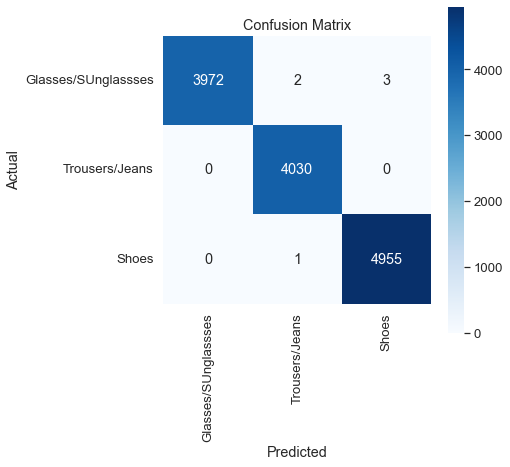

406/406 [==============================] - 17s 41ms/step - loss: 0.0021 - accuracy: 0.9995


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


---Starting trial: run-2
{'filter_size': 3, 'filter_num': '32'}
Epoch 1/5
203/203 - 79s - loss: 0.0702 - accuracy: 0.9809 - val_loss: 0.0139 - val_accuracy: 0.9981 - 79s/epoch - 389ms/step
Epoch 2/5
203/203 - 79s - loss: 0.0159 - accuracy: 0.9967 - val_loss: 0.0079 - val_accuracy: 0.9992 - 79s/epoch - 390ms/step
Epoch 3/5
203/203 - 79s - loss: 0.0098 - accuracy: 0.9986 - val_loss: 0.0071 - val_accuracy: 0.9992 - 79s/epoch - 389ms/step
Epoch 4/5
203/203 - 69s - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.0031 - val_accuracy: 0.9996 - 69s/epoch - 342ms/step
Epoch 5/5
203/203 - 70s - loss: 0.0042 - accuracy: 0.9994 - val_loss: 0.0124 - val_accuracy: 0.9951 - 70s/epoch - 345ms/step
406/406 [==============================] - 20s 48ms/step


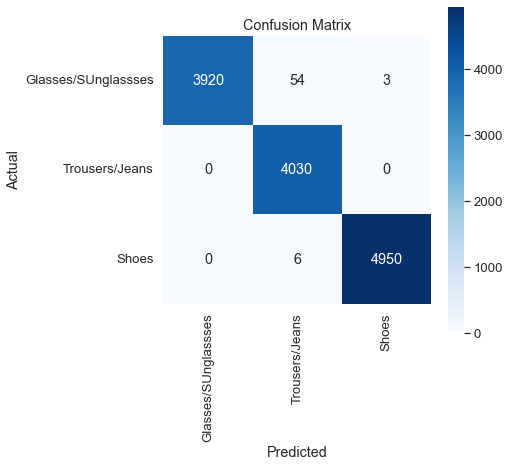

406/406 [==============================] - 17s 42ms/step - loss: 0.0124 - accuracy: 0.9951


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


---Starting trial: run-3
{'filter_size': 3, 'filter_num': '64'}
Epoch 1/5
203/203 - 73s - loss: 0.0877 - accuracy: 0.9729 - val_loss: 0.0225 - val_accuracy: 0.9934 - 73s/epoch - 358ms/step
Epoch 2/5
203/203 - 73s - loss: 0.0128 - accuracy: 0.9980 - val_loss: 0.0078 - val_accuracy: 0.9994 - 73s/epoch - 359ms/step
Epoch 3/5
203/203 - 72s - loss: 0.0087 - accuracy: 0.9988 - val_loss: 0.0050 - val_accuracy: 0.9995 - 72s/epoch - 353ms/step
Epoch 4/5
203/203 - 74s - loss: 0.0072 - accuracy: 0.9986 - val_loss: 0.0083 - val_accuracy: 0.9988 - 74s/epoch - 367ms/step
Epoch 5/5
203/203 - 75s - loss: 0.0067 - accuracy: 0.9994 - val_loss: 0.0037 - val_accuracy: 0.9996 - 75s/epoch - 369ms/step
406/406 [==============================] - 19s 46ms/step


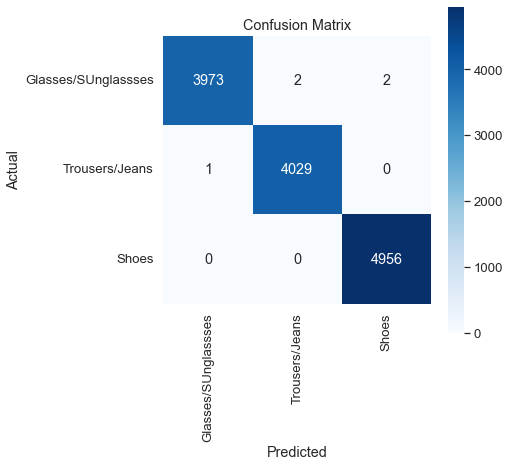

406/406 [==============================] - 18s 45ms/step - loss: 0.0037 - accuracy: 0.9996


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


---Starting trial: run-4
{'filter_size': 3, 'filter_num': '96'}
Epoch 1/5
203/203 - 73s - loss: 0.0851 - accuracy: 0.9751 - val_loss: 0.0121 - val_accuracy: 0.9985 - 73s/epoch - 360ms/step
Epoch 2/5
203/203 - 77s - loss: 0.0113 - accuracy: 0.9986 - val_loss: 0.0088 - val_accuracy: 0.9992 - 77s/epoch - 378ms/step
Epoch 3/5
203/203 - 75s - loss: 0.0102 - accuracy: 0.9988 - val_loss: 0.0057 - val_accuracy: 0.9995 - 75s/epoch - 368ms/step
Epoch 4/5
203/203 - 74s - loss: 0.0074 - accuracy: 0.9993 - val_loss: 0.0134 - val_accuracy: 0.9993 - 74s/epoch - 366ms/step
Epoch 5/5
203/203 - 75s - loss: 0.0060 - accuracy: 0.9992 - val_loss: 0.0031 - val_accuracy: 0.9995 - 75s/epoch - 371ms/step
406/406 [==============================] - 19s 45ms/step


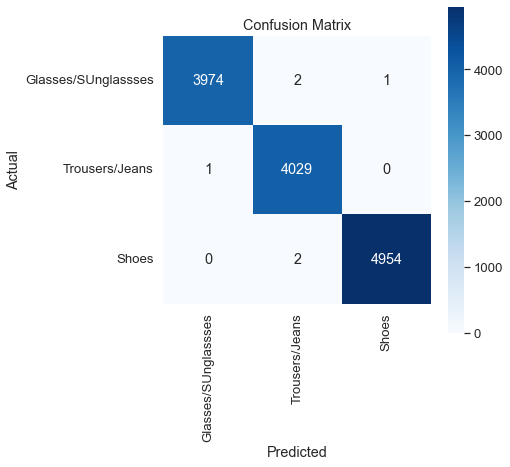

406/406 [==============================] - 16s 40ms/step - loss: 0.0031 - accuracy: 0.9995


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


---Starting trial: run-5
{'filter_size': 5, 'filter_num': '128'}
Epoch 1/5
203/203 - 74s - loss: 0.0888 - accuracy: 0.9739 - val_loss: 0.0258 - val_accuracy: 0.9934 - 74s/epoch - 364ms/step
Epoch 2/5
203/203 - 76s - loss: 0.0132 - accuracy: 0.9982 - val_loss: 0.0062 - val_accuracy: 0.9992 - 76s/epoch - 373ms/step
Epoch 3/5
203/203 - 76s - loss: 0.0092 - accuracy: 0.9987 - val_loss: 0.0044 - val_accuracy: 0.9996 - 76s/epoch - 373ms/step
Epoch 4/5
203/203 - 73s - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0041 - val_accuracy: 0.9994 - 73s/epoch - 362ms/step
Epoch 5/5
203/203 - 74s - loss: 0.0039 - accuracy: 0.9997 - val_loss: 0.0028 - val_accuracy: 0.9995 - 74s/epoch - 365ms/step
406/406 [==============================] - 17s 41ms/step


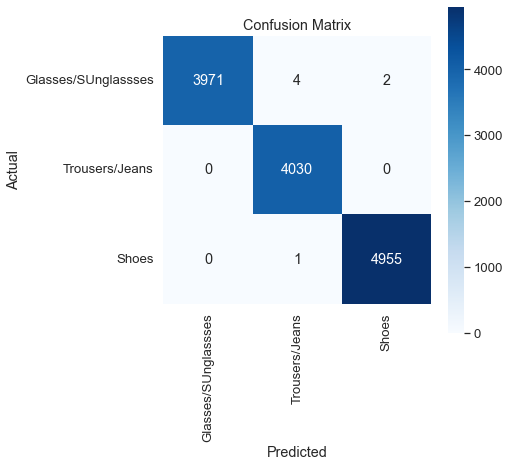

406/406 [==============================] - 19s 48ms/step - loss: 0.0028 - accuracy: 0.9995


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


---Starting trial: run-6
{'filter_size': 5, 'filter_num': '32'}
Epoch 1/5
203/203 - 73s - loss: 0.1013 - accuracy: 0.9661 - val_loss: 0.0158 - val_accuracy: 0.9988 - 73s/epoch - 359ms/step
Epoch 2/5
203/203 - 75s - loss: 0.0153 - accuracy: 0.9983 - val_loss: 0.0096 - val_accuracy: 0.9986 - 75s/epoch - 368ms/step
Epoch 3/5
203/203 - 71s - loss: 0.0146 - accuracy: 0.9975 - val_loss: 0.0078 - val_accuracy: 0.9993 - 71s/epoch - 350ms/step
Epoch 4/5
203/203 - 68s - loss: 0.0077 - accuracy: 0.9992 - val_loss: 0.0039 - val_accuracy: 0.9995 - 68s/epoch - 334ms/step
Epoch 5/5
203/203 - 72s - loss: 0.0064 - accuracy: 0.9991 - val_loss: 0.0039 - val_accuracy: 0.9995 - 72s/epoch - 354ms/step
406/406 [==============================] - 17s 42ms/step


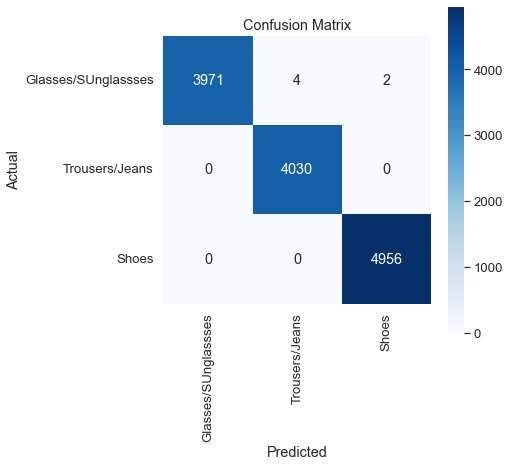

406/406 [==============================] - 16s 40ms/step - loss: 0.0039 - accuracy: 0.9995


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


INFO:tensorflow:Assets written to: Logs/Model 1/fit/run-0\assets


---Starting trial: run-7
{'filter_size': 5, 'filter_num': '64'}
Epoch 1/5


In [ ]:
        
#Train the model with the different hyperparameters
session_num = 1
for filter_size in HP_FILTER_SIZE.domain.values:
    for filter_num in HP_FILTER_NUM.domain.values:
        hparams ={
        HP_FILTER_SIZE: filter_size,
        HP_FILTER_NUM : filter_num
        }
        
        run_name = "run-%d" % session_num
        print('---Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('Logs/Model 1/hparam_tuning/' + run_name, hparams, session_num)
        
        session_num += 1

In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'Logs/Model 1/hparam_tuning'


In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'Logs/Model 1/fit'